In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_validate

In [2]:
PP1_metadata = pd.read_csv('Metadata/PP1_metadata.tsv', sep='\t')
PP2_metadata = pd.read_csv('Metadata/PP2_metadata.tsv', sep='\t')

# PP1

In [3]:
chunksize = 50000
PP1_pres_abs = pd.DataFrame()

for PP1_chunk in pd.read_csv('Data/PP1_table.tsv', sep='\t', chunksize=chunksize):
    PP1_chunk[PP1_metadata['Sample'].to_list()] = PP1_chunk[PP1_metadata['Sample'].to_list()].astype(bool).astype(int)
    PP1_pres_abs = pd.concat([PP1_pres_abs,PP1_chunk])

In [4]:
PP1_pres_abs = PP1_pres_abs[PP1_metadata['Sample'].to_list()]
PP1_t = PP1_pres_abs.to_numpy()
PP1_t = PP1_t.transpose()
PP1_labels = np.array([1 if PP1_metadata[PP1_metadata['Sample'] == i]['EUCI'].values == 'Yes' else 0 for i in PP1_pres_abs.columns.to_list()])
print(PP1_t.shape)
print(PP1_labels.shape)

(2997, 561946)
(2997,)


In [5]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [6]:
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

PP1_t, PP1_labels = shuffle(PP1_t, PP1_labels, random_state=23)
classifier = LinearSVC(penalty='l2',
                       C=0.001,
                       tol=1e-4,
                       class_weight='balanced',
                       random_state=23,
                       max_iter=1000)
results = cross_validate(classifier, PP1_t, PP1_labels, cv=10, scoring=['balanced_accuracy','roc_auc'], return_estimator=True)

In [7]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    return([imp,names])

features_names = pd.read_csv('Data/PP1_table.tsv',sep = '\t',header = 0,usecols = [0])['ASV']
features_taxa = pd.read_csv('Data/PP1_table.tsv',sep = '\t',header = 0,usecols = [1])['Taxonomy']

In [8]:
print(features_names)
print(features_taxa)

0         000029d0cc6b7b253e6abae864b50d84
1         000059e2f525504982082032361f8241
2         00006573055a3b9c309d8b6a113cafd8
3         00008931f4546bbfe04dc090f5f6cda7
4         0000c01fb9079f95b749bf67a4537a04
                        ...               
561941    ffff94b458e014a32b5600882aa5ba1f
561942    ffffb3a83de6794a0c434dbc67589926
561943    ffffb6138c72cb6be38a840ee773fc91
561944    ffffc2cb2c1bfe14d04fb5874874b9c6
561945    ffffffaa9f19d66d662ad0757523c3b3
Name: ASV, Length: 561946, dtype: object
0         d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...
1         d__Bacteria; p__Patescibacteria; c__Parcubacte...
2         d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...
3         d__Bacteria; p__Patescibacteria; c__Berkelbact...
4         d__Bacteria; p__Acidobacteriota; c__Holophagae...
                                ...                        
561941    d__Bacteria; p__Acidobacteriota; c__Acidobacte...
561942    d__Bacteria; p__Proteobacteria; c__Alphaproteo...
561943

Mean balanced accuracy: 0.9956521739130434
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9782608695652174, 0.9782608695652174, 1.0]


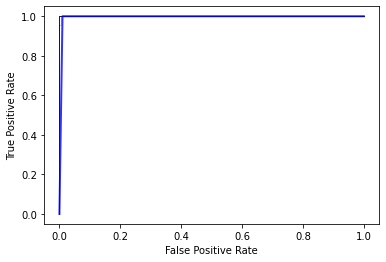

In [9]:
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt

cv = StratifiedKFold(n_splits=10)
PP1_t, PP1_labels = shuffle(PP1_t, PP1_labels, random_state=23)
classifier = LinearSVC(penalty='l2',
                       C=0.001,
                       tol=1e-4,
                       class_weight='balanced',
                       random_state=23,
                       max_iter=1000)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

bal_acc_list = []
feature_imp_list = []

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(PP1_t, PP1_labels)):
    # Train
    classifier.fit(PP1_t[train], PP1_labels[train])
    
    # Get balanced accuracy
    balanced_accuracy = balanced_accuracy_score(PP1_labels[test], classifier.predict(PP1_t[test]))
    bal_acc_list.append(balanced_accuracy)
    
    # Get Importance
    feat_imp = f_importances(classifier.coef_, features_names)
    feature_imp_list.append(feat_imp)
    
    # Get ROC curve
    viz = plot_roc_curve(classifier, PP1_t[test], PP1_labels[test],
                         color='black',
                         alpha=0.2, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
ax.get_legend().remove()
plt.savefig('2_SVM_EUCI/PP1_roc.pdf')
    
print('Mean balanced accuracy: ' + str(np.mean(bal_acc_list)))
print(bal_acc_list)
    


                                     ASV  \
0       000029d0cc6b7b253e6abae864b50d84   
1       000059e2f525504982082032361f8241   
2       00006573055a3b9c309d8b6a113cafd8   
3       00008931f4546bbfe04dc090f5f6cda7   
4       0000c01fb9079f95b749bf67a4537a04   
...                                  ...   
561941  ffff94b458e014a32b5600882aa5ba1f   
561942  ffffb3a83de6794a0c434dbc67589926   
561943  ffffb6138c72cb6be38a840ee773fc91   
561944  ffffc2cb2c1bfe14d04fb5874874b9c6   
561945  ffffffaa9f19d66d662ad0757523c3b3   

                                                 Taxonomy  Importance  
0       d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...   -0.000051  
1       d__Bacteria; p__Patescibacteria; c__Parcubacte...    0.000000  
2       d__Bacteria; p__Bacteroidota; c__Bacteroidia; ...    0.000000  
3       d__Bacteria; p__Patescibacteria; c__Berkelbact...   -0.000263  
4       d__Bacteria; p__Acidobacteriota; c__Holophagae...    0.000000  
...                                    

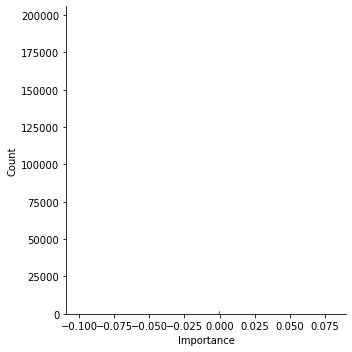

In [10]:
import seaborn as sns

feature_importance = np.array([np.array(i[0]) for i in feature_imp_list])
feature_importance_means = np.mean(feature_importance, axis=0)

importance_df = pd.DataFrame({'ASV':features_names,'Taxonomy':features_taxa,'Importance':feature_importance_means[0]})
print(importance_df)

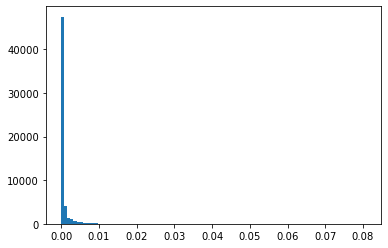

In [18]:
non_null_df = importance_df[importance_df["Importance"] > 0]
plt.hist(non_null_df["Importance"],bins=100)
plt.show()
plt.close()

In [47]:
print(len(non_null_df[non_null_df['Taxonomy'].str.contains("; g__")]))
print(len(non_null_df['Taxonomy']))
print(len(non_null_df[non_null_df['Taxonomy'].str.contains("; g__")]) / len(non_null_df['Taxonomy']))
print(len(non_null_df[non_null_df['Taxonomy'].str.contains("; g__")]) - len(non_null_df['Taxonomy']))

pos_df_no_genus = non_null_df[non_null_df['Taxonomy'].str.contains("; g__") == False]
print(len(pos_df_no_genus[pos_df_no_genus['Taxonomy'].str.contains("; f__")]))

pos_df_family = pos_df_no_genus[pos_df_no_genus['Taxonomy'].str.contains("; f__")]
pos_df_order = pos_df_no_genus[~pos_df_no_genus['Taxonomy'].str.contains("; f__")]
pos_df_order = pos_df_order[pos_df_order['Taxonomy'].str.contains("; o__")]
print(len(pos_df_order))

family_counts = pos_df_family['Taxonomy'].value_counts()
order_counts = pos_df_order['Taxonomy'].value_counts()

family_counts.to_csv('2_SVM_EUCI/PP1_no_genus_family_counts.csv')
order_counts.to_csv('2_SVM_EUCI/PP1_no_genus_No_family_order_counts.csv')
print(family_counts)
print(order_counts)


48636
56494
0.8609055828937586
-7858
4312
967
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Burkholderiales; f__Comamonadaceae          645
d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Acetobacterales; f__Acetobacteraceae        414
d__Bacteria; p__Actinobacteriota; c__Actinobacteria; o__Micrococcales; f__Microbacteriaceae            321
d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Sphingomonadales; f__Sphingomonadaceae      287
d__Bacteria; p__Proteobacteria; c__Alphaproteobacteria; o__Rhodobacterales; f__Rhodobacteraceae        193
                                                                                                      ... 
d__Bacteria; p__Actinobacteriota; c__Actinobacteria; o__Streptosporangiales; f__Thermomonosporaceae      1
d__Bacteria; p__Proteobacteria; c__Gammaproteobacteria; o__Burkholderiales; f__Sulfuricellaceae          1
d__Bacteria; p__Firmicutes; c__Thermacetogenia; o__Thermacetogeniales; f__Thermacetogeniaceae     

Mean: 99.565% balanced acccuracy
- [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9782608695652174, 0.9782608695652174, 1.0]


# PP2

In [48]:
chunksize = 50000
PP2_pres_abs = pd.DataFrame()

for PP2_chunk in pd.read_csv('Data/PP2_table.tsv', sep='\t', chunksize=chunksize):
    PP2_chunk[PP2_metadata['Sample'].to_list()] = PP2_chunk[PP2_metadata['Sample'].to_list()].astype(bool).astype(int)
    PP2_pres_abs = pd.concat([PP2_pres_abs,PP2_chunk])

In [49]:
PP2_pres_abs = PP2_pres_abs[PP2_metadata['Sample'].to_list()]
PP2_t = PP2_pres_abs.to_numpy()
PP2_t = PP2_t.transpose()
PP2_labels = np.array([1 if PP2_metadata[PP2_metadata['Sample'] == i]['EUCI'].values == 'Yes' else 0 for i in PP2_pres_abs.columns.to_list()])
print(PP2_t.shape)
print(PP2_labels.shape)

(1929, 488610)
(1929,)


Mean balanced accuracy: 0.9913024469360412
[0.96359918200409, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9833333333333334, 0.9833333333333334, 1.0, 0.9827586206896552]


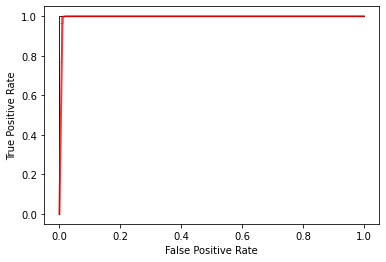

In [53]:
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle

def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    return([imp,names])

features_names = pd.read_csv('Data/PP2_table.tsv',sep = '\t',header = 0,usecols = [0])['ASV']
features_taxa = pd.read_csv('Data/PP2_table.tsv',sep = '\t',header = 0,usecols = [1])['Taxonomy']

cv = StratifiedKFold(n_splits=10)
PP2_t, PP2_labels = shuffle(PP2_t, PP2_labels, random_state=23)
classifier = LinearSVC(penalty='l2',
                       C=0.001,
                       tol=1e-4,
                       class_weight='balanced',
                       random_state=23,
                       max_iter=1000)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

bal_acc_list = []
feature_imp_list = []

fig, ax = plt.subplots()
for i, (train, test) in enumerate(cv.split(PP2_t, PP2_labels)):
    # Train
    classifier.fit(PP2_t[train], PP2_labels[train])
    
    # Get balanced accuracy
    balanced_accuracy = balanced_accuracy_score(PP2_labels[test], classifier.predict(PP2_t[test]))
    bal_acc_list.append(balanced_accuracy)
    
    # Get Importance
    feat_imp = f_importances(classifier.coef_, features_names)
    feature_imp_list.append(feat_imp)
    
    # Get ROC curve
    viz = plot_roc_curve(classifier, PP2_t[test], PP2_labels[test],
                         color='black',
                         alpha=0.2, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='r',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
ax.get_legend().remove()
plt.savefig('2_SVM_EUCI/PP2_roc.pdf')
    
print('Mean balanced accuracy: ' + str(np.mean(bal_acc_list)))
print(bal_acc_list)

Mean: 99.130% balanced accuracy
- [0.96359918200409, 1.0, 1.0, 1.0, 1.0, 1.0, 0.9833333333333334, 0.9833333333333334, 1.0, 0.9827586206896552]

In [57]:
import seaborn as sns

feature_importance = np.array([np.array(i[0]) for i in feature_imp_list])
feature_importance_means = np.mean(feature_importance, axis=0)

importance_df = pd.DataFrame({'ASV':features_names,'Taxonomy':features_taxa,'Importance':feature_importance_means[0]})
print(importance_df)

non_null_df = importance_df[importance_df['Importance'] > 0]
print(len(non_null_df[non_null_df['Taxonomy'].str.contains("; g__")]))
print(len(non_null_df['Taxonomy']))
print(len(non_null_df[non_null_df['Taxonomy'].str.contains("; g__")]) / len(non_null_df['Taxonomy']))
print(len(non_null_df[non_null_df['Taxonomy'].str.contains("; g__")]) - len(non_null_df['Taxonomy']))

pos_df_no_genus = non_null_df[non_null_df['Taxonomy'].str.contains("; g__") == False]
print(len(pos_df_no_genus[pos_df_no_genus['Taxonomy'].str.contains("; f__")]))

pos_df_family = pos_df_no_genus[pos_df_no_genus['Taxonomy'].str.contains("; f__")]
pos_df_order = pos_df_no_genus[~pos_df_no_genus['Taxonomy'].str.contains("; f__")]
pos_df_order = pos_df_order[pos_df_order['Taxonomy'].str.contains("; o__")]
print(len(pos_df_order))

family_counts = pos_df_family['Taxonomy'].value_counts()
order_counts = pos_df_order['Taxonomy'].value_counts()

family_counts.to_csv('2_SVM_EUCI/PP2_no_genus_family_counts.csv')
order_counts.to_csv('2_SVM_EUCI/PP2_no_genus_No_family_order_counts.csv')
print(family_counts)
print(order_counts)

                                     ASV  \
0       00000fd81254be225d7c3d5014203af1   
1       00001f68d7df7ff09fd006ed75c7a3d1   
2       0000475b997f9ce5f195f53945ff2415   
3       0000623ae3775648f959afd6a94ad25a   
4       000075dcd27d07a9478887ada062783e   
...                                  ...   
488605  ffff6a9757b10e7bdfb70a66d2745e02   
488606  ffffb2e973b5618be5ec1b2b5e393fef   
488607  ffffcaf27611ae4625ca460fe5a943be   
488608  fffff096390ac0a68d6aeff2713794b9   
488609  fffff2a2e535e0105afb2113a8e1ee4c   

                                                 Taxonomy  Importance  
0                                             d__Bacteria   -0.000082  
1                                             d__Bacteria   -0.000231  
2       d__Bacteria; p__Proteobacteria; c__Gammaproteo...   -0.000404  
3                                             d__Bacteria    0.000000  
4                                             d__Bacteria   -0.000216  
...                                    